# Μέρος 2. Χρονο-Συχνοτική Ανάλυση με Συστοιχία Ζωνοπερατών Φίλτρων


#### Οι Ασκήσεις πραγματοποιήθηκαν από τους : ΒΑΣΙΛΕΙAΔΗΣ ΔΗΜΉΤΡΙΟΣ AM: 03122111/el22111 - ΓΡΗΓΟΡΙΟΣ ΣΤΑΜΑΤΟΠΟΥΛΟΣ ΑΜ: 03122039/el22039.        Η Βιβλιογραφία μας αποτελείται από:
* Το documentation όλων των διαθέσιμων βιβλιοθηκών που αναφέρονται στο αρχείο "PYTHON GUIDE" στη διαδασκαλική ιστοσελίδα του Helios, 
* Όλα τα σετ διαφανειών που είναι ανεβασμένα στην παραπάνω ιστοσελίδα,
* Καθώς και πληροφορίες από δίαφορες άλλες όπως:


    *  https://dsp.stackexchange.com/ , 
    *  https://stackoverflow.com/search?q=jupyter+notebook , 
    *  https://ieeexplore.ieee.org/Xplore/home.jsp , 
    *  https://www.wikipedia.org/ , 
    *  https://arxiv.org/abs/2306.08436 , 
    *  https://sites.google.com/berkeley.edu/ee123-sp20/python , 
    *  https://github.com/openlists/DSPResources και άλλες ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf  # Για αποθήκευση σε .wav
from IPython.display import Audio, display
import librosa
import scipy.signal as sig

In [2]:
# Χρήσιμες Συναρτήσεις από το πρώτο μέρος
def calculate_spectrum(frame):
    fft_result = np.fft.fft(frame)
    power_spectrum = np.abs(fft_result[:N//2])**2
    PN = 90.302  
    power_spectrum_db = 10 * np.log10(power_spectrum) + PN
    return power_spectrum_db


def bark(frequencies):
    return 13 * np.arctan(0.00076 * frequencies) + 3.5 * np.arctan((frequencies / 7500) ** 2)



def sf(pm):
    sf = np.zeros((len(pm), len(pm)))
    for b in range(0, len(pm)):
        if pm[b] > 0:
            for a in range (0, len(pm)):
                diff = bark(a) - bark(b)
                if -3 <= diff < -1:
                    sf[a][b] = 17*diff - 0.4*pm[b] + 11
                if -1 <= diff < 0:
                    sf[a][b] = (0.4*pm[b] + 6)*diff
                if 0 <= diff < 1:
                    sf[a][b] = -17*diff
                if 1 <= diff < 8:
                    sf[a][b] = (0.15*pm[b] - 17)*diff -0.15*pm[b]
    return sf



def Tg(Tq, TTM, TNM):
    tg = np.zeros(len(Tq))
    for i in range (0, len(Tq)):
        tg[i] = 10 * np.log10(10**(0.1 * Tq[i]) + np.sum(10**(0.1 * TTM[i])) + np.sum(10**(0.1 * TNM[i])))
    return tg



def Tq(frame):
    tq = np.zeros(len(frame))
    for f in range(1, len(frame)): 
        tq[f] = 3.64 * (f / 1000) ** -0.8 - 6.5 * np.exp(-0.6 * (f / 1000 - 3.3) ** 2) + 10 ** -3 * (f / 1000) ** 4

    return tq


def ttm(sf, ptm):
    ttm = np.zeros((len(ptm), len(ptm)))
    
    for b in range(0, len(ptm)):
        for a in range (0, len(ptm)):
            ttm[a][b] = ptm[b] - 0.275*bark(b) + sf[a][b] - 6.025
    
    return ttm


def tnm(sf, pnm):
    tnm = np.zeros((len(pnm), len(pnm)))
    for b in range(0, len(pnm)):
        for a in range (0, len(pnm)):
            tnm[a][b] = pnm[b] - 0.175*bark(b) + sf[a][b] - 2.025
    
    return tnm


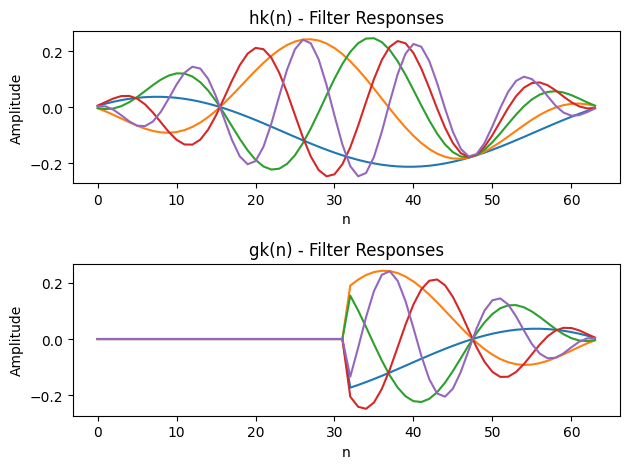

In [3]:
# Βήμα 2.0 : Συστοιχία Ζωνοπερατών Φίλτρων (Filterbank)

M = 32 # φίλτρα ανάλυσης και σύνθεσης

def h(M):
    L = 2 * M
    analysis = np.zeros((M, L))
    synthesis = np.zeros((M, L))
    
    for n in range(L):
        for k in range(M):
            # Υπολογισμός του hk(n)
            analysis[k, n] = np.sin((n + 1/2) * np.pi / (2 * M)) * (np.sqrt(2 / M)) * np.cos((2 * n + M + 1) * (2 * k + 1) * np.pi / (4 * M))
            
            # Υπολογισμός του gk(n)
            synthesis[k, n] = analysis[k, 2 * M - 1 - n]
    
    return analysis, synthesis

analysis, synthesis = h(M)

# Εμφάνιση των πρώτων 5 φίλτρων για το hk και gk
for k in range(5): 
    plt.subplot(2, 1, 1)
    plt.plot(analysis[k, :])
    plt.title("hk(n) - Filter Responses")
    plt.xlabel("n")
    plt.ylabel("Amplitude")
    
    plt.subplot(2, 1, 2)
    plt.plot(synthesis[k, :])
    plt.title("gk(n) - Filter Responses")
    plt.xlabel("n")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()



    

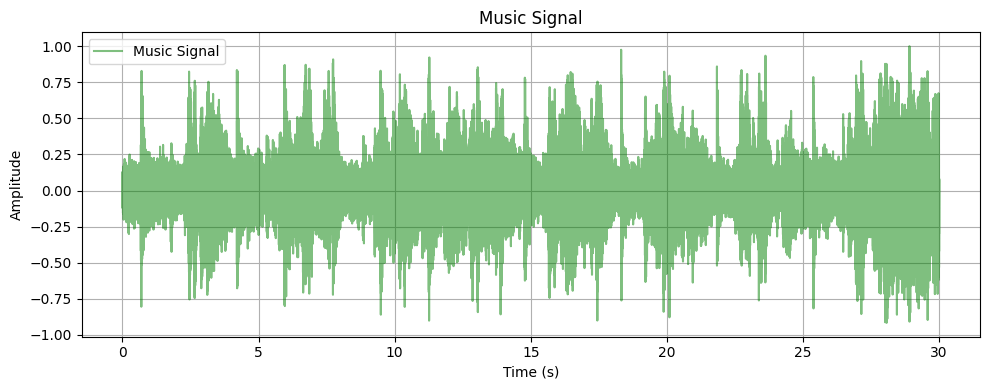

Συνολικά πλαίσια: 2583


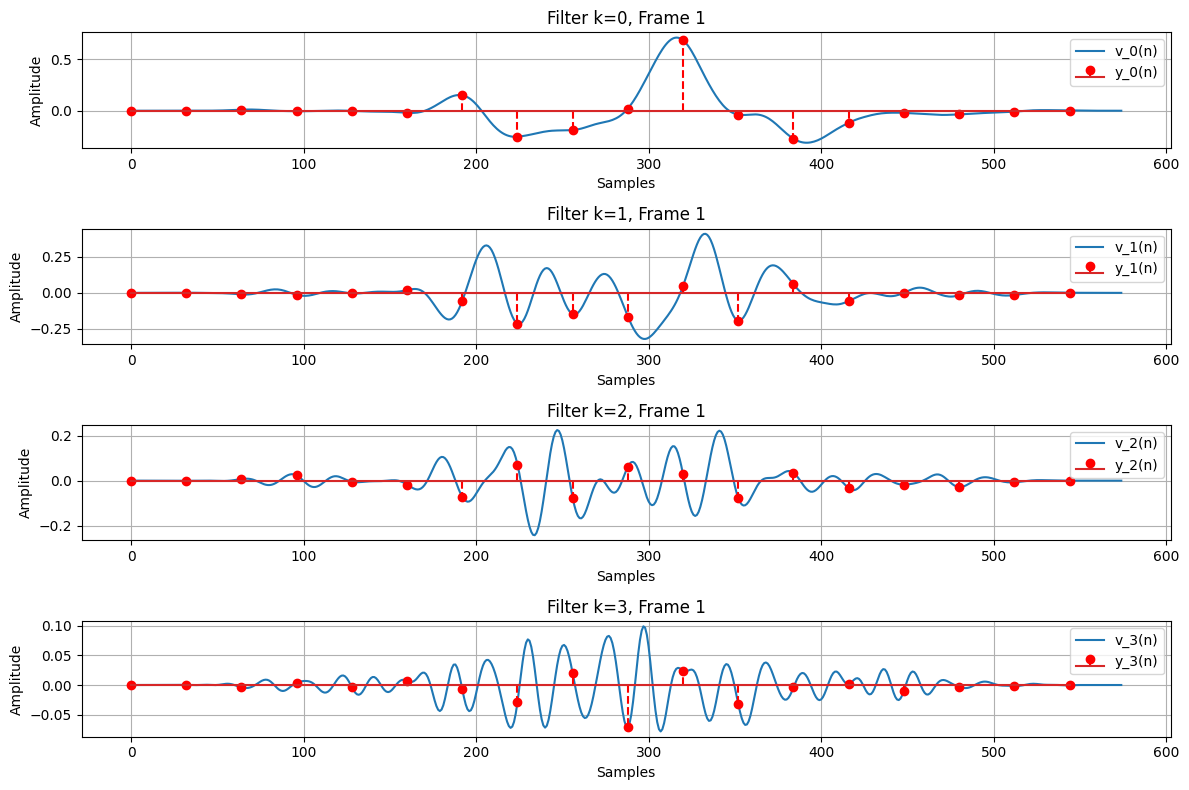

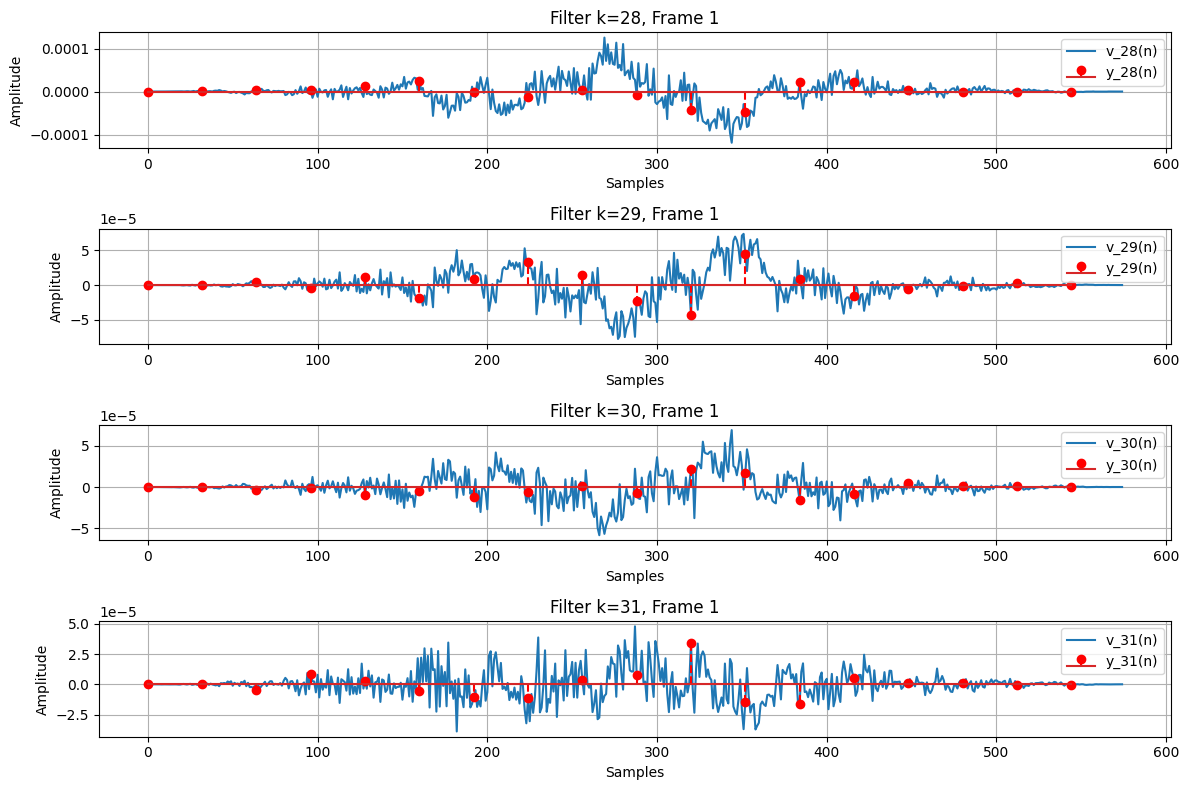

In [4]:

# Φόρτωση σήματος
audio_path = 'DSP25_LabProject2_Material/music_dsp.wav'
audio_signal, sr = librosa.load(audio_path, sr=44100,  mono=True)  

# Κανονοποιούμε το σήμα
audio_signal = audio_signal / np.max(np.abs(audio_signal))

N = 512
Μ = 32

# Παραθυροποιούμε το σήμα χρησιμοποιώντας παραθυρο Hann
frames = librosa.util.frame(audio_signal, frame_length=N, hop_length=N)

# Το εφαρμόζουμε σε κάθε frame
han_window = np.hanning(N)
frames_windowed = frames * han_window[:, np.newaxis] ## 2D πίνακας (512 x num_frames)


# Plot of the music signal
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(audio_signal)) / sr, audio_signal, label='Music Signal', color='g', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Music Signal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

num_frames = len(audio_signal) // N
print(f"Συνολικά πλαίσια: {num_frames}")

analysis, synthesis = h(M)

def analysis_filter_bank(frame, analysis_filters): # Είσοδος 1D frame
    M, L = analysis_filters.shape
    y = []
    for k in range(M):
        hk = analysis_filters[k, :]
        vk = np.convolve(frame, hk, mode='full')
        yk = vk[::M] # Decimation
        y.append(yk)
    return y

# Επεξεργασία ΠΡΩΤΟΥ ΠΛΑΙΣΙΟΥ μόνο για παράδειγμα
selected_frame = 1
frame_data = frames_windowed[:, selected_frame] # 1D πίνακας (512,)
y_components = analysis_filter_bank(frame_data, analysis)

# Πλοττάρισμα για 4 φίλτρα

selected_k1= [0, 1, 2, 3]
selected_k2 =[28, 29, 30, 31]

plt.figure(figsize=(12, 8))


for i, k in enumerate(selected_k1):
    hk = analysis[k, :]
    vk = np.convolve(frame_data, hk, mode='full')
    yk = y_components[k]
    
    n_vk = np.arange(len(vk))
    n_yk = np.arange(0, len(vk), M)
    
    plt.subplot(4, 1, i+1)
    plt.plot(n_vk, vk, label=f'v_{k}(n)')
    plt.stem(n_yk, yk, linefmt='r--', markerfmt='ro', label=f'y_{k}(n)')
    plt.title(f'Filter k={k}, Frame {selected_frame}')
    plt.xlabel('Samples'), plt.ylabel('Amplitude')
    plt.legend(), plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

for i, k in enumerate(selected_k2):
    hk = analysis[k, :]
    vk = np.convolve(frame_data, hk, mode='full')
    yk = y_components[k]
    
    n_vk = np.arange(len(vk))
    n_yk = np.arange(0, len(vk), M)
    
    plt.subplot(4, 1, i+1)
    plt.plot(n_vk, vk, label=f'v_{k}(n)')
    plt.stem(n_yk, yk, linefmt='r--', markerfmt='ro', label=f'y_{k}(n)')
    plt.title(f'Filter k={k}, Frame {selected_frame}')
    plt.xlabel('Samples'), plt.ylabel('Amplitude')
    plt.legend(), plt.grid(True)

plt.tight_layout()
plt.show()

      

In [5]:
# Βήμα 2.2: Κβαντοποίηση

# Number of coding bits per y sample 
def Bk(Tg, B=16):
    R = 2**16
    Bk = int(np.log2(R / np.min(Tg)) - 1)
    
    return Bk


# Adaptive quantizer
def adaptive_quantizer(y, Tg):
    
    levels = 2**Bk(Tg,16)
    # Step of quantization
    ymin = np.min(y)
    ymax = np.max(y)
    D = (ymax - ymin) / levels

    # Quantization
    adaptive_quantizer_result = np.round(y / D) 
    
    return adaptive_quantizer_result


# Non adaptive quantizer
def non_adaptive_quantizer(y, B=8):

    # Step of quantization
    D = 2 / (2**B) #xmax - xmin = 1 - (-1) = 2

    # Quantization
    non_adaptive_quantizer_result = np.round(y / D)
    
    return non_adaptive_quantizer_result
